In [1]:
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt

from tqdm import tqdm

from scipy.stats import entropy


In [2]:
def plotter_kl(kl, phi_g, chi, saveFlag):
    plot_labels = [100, 1000, 10000, 100000, 1000000]
    betas = [1, 5, 10]
    
    fig, ax = plt.subplots(figsize = (10, 6))
    ctr = 1
    for idx, _ in enumerate(plot_labels):
        ax.plot(betas, kl[idx], marker = ".", label = str(plot_labels[idx]), color = "k", alpha = (ctr/(len(plot_labels) + 1))**2, linewidth = 3, markersize = 9)
        ctr += 1
    
    plt.legend(loc =  "upper right")
    
    ax.set_xlabel(r"$\beta$", fontsize = 12)
    ax.set_ylabel(r"$\sum_{r=1}^{N_{\text{\Rep}}}KL_{r}$", fontsize = 12)
    ax.set_xticks(BETAs)
        
    title = r"$\phi_1^{\text{global}}$ = " + f"{phi_g:.3f}" + "\n" + r"$\chi = $" + f"{chi:.3f}"
    
    fig.suptitle(title)

    if saveFlag:
        output_filepath = f"../analysed_data/chi-{chi:.3f}/phi_g-{phi_g:.3f}"
        output_filename = f"KL-vs-beta.png"

        if not os.path.exists(output_filepath):
            os.makedirs(output_filepath)
        
        file = os.path.join(output_filepath, output_filename)     
        
        plt.savefig(file, dpi = 400)
        plt.close()

        print(f"Saved @ {file}")

def plotter_landscapes(df_merged, phi_g, chi, beta, nSteps, replica, saveFlag):
    fig, ax = plt.subplots(1, 2, figsize = (12, 6))
    scatter = ax[0].scatter(df_merged["phi11"], df_merged["eta1"], c = df_merged["probability_Q"], cmap = "viridis")
    ax[0].set_title("Brute Force\n\n\n\n")
    plt.colorbar(scatter, ax = ax[0], label = "Probability")
    ax[0].set_xlabel(r"$\phi_{11}$", fontsize = 12)
    ax[0].set_ylabel(r"$\eta_1$", fontsize = 12)
    
    ax[1].scatter(df_merged["phi11"], df_merged["eta1"], c = df_merged["probability_P"], cmap = "viridis")
    title = "MCMC\n\n" + r"$\beta=$" + f"{beta:.3f}" + "\nSteps = " + f"{nSteps}" + "\nReplica " + f"{replica}" 
    ax[1].set_title(title)
    plt.colorbar(scatter, ax = ax[1], label = "Probability")
    ax[1].set_xlabel(r"$\phi_{11}$", fontsize = 12)
    ax[1].set_ylabel(r"$\eta_1$", fontsize = 12)
    
    title = r"$\phi_1^{\text{global}}$ = " + f"{phi_g:.3f}" + "\n" + r"$\chi = $" + f"{chi:.3f}"
        
    fig.suptitle(title)
    
    fig.tight_layout()

    if saveFlag:
        output_filepath = f"../analysed_data/chi-{chi:.3f}/phi_g-{phi_g:.3f}/steps-{nSteps}/beta-{beta}/"
        output_filename = f"landscape-replica{replica}.png"

        if not os.path.exists(output_filepath):
            os.makedirs(output_filepath)
        
        file = os.path.join(output_filepath, output_filename)     
        
        plt.savefig(file, dpi = 400)
        plt.close()

        print(f"Saved @ {file}")

In [9]:
BETAs = [1, 5, 10]
nSTEPSs = [100, 1000, 10000, 100000, 1000000]
REPLICAs = [1, 2, 3, 4, 5]
# PHI_1_GLOBALs = np.linspace(1e-3, 1-1e-3, 10)
PHI_1_GLOBALs = [0.555]
CHIs = [2.556]
# CHIs = np.linspace(1, 3, 10)

for phi_g in tqdm(PHI_1_GLOBALs):
    for chi in CHIs:
        kl = []
        for nSteps in nSTEPSs:
            kl_s = []
            for beta in BETAs:
                kl_replica = []
                for replica in REPLICAs:
                    df_brute = pd.read_pickle(f"../data/brute_force/mesh-100/chi-{chi:.3f}/phi_g-{phi_g:.3f}/df/df_brute.pkl", compression = "gzip")
                    
                    df_brute["boltzmann_factor"] = np.exp(-beta*df_brute["F"])
                    Z = df_brute["boltzmann_factor"].sum()
                    df_brute["probability_Q"] = df_brute["boltzmann_factor"]/Z
                    
                    
                    df_mcmc = pd.read_pickle(f"../data/mcmc/mesh-100/chi-{chi:.3f}/phi_g-{phi_g:.3f}/steps-{nSteps}/beta-{beta}/df/df_mcmc-replica{replica}.pkl", compression = "gzip")
                    df_counts = df_mcmc.groupby(["phi11", "eta1"]).size().reset_index(name="count")
                    df_counts["probability_P"] = df_counts["count"]/df_counts["count"].sum()
                    
                    
                    df_merged = pd.merge(df_counts[['phi11', 'eta1', 'probability_P']], df_brute[['phi11', 'eta1', 'probability_Q']], on=['phi11', 'eta1'], how='outer')
                    df_merged['probability_P'] = df_merged['probability_P'].fillna(0)  # Unvisited states get P(x,y) = 0
                    epsilon = 1e-10
                    df_merged['probability_Q'] = df_merged['probability_Q'].fillna(epsilon)
                    
                    P = df_merged["probability_P"].values
                    Q = df_merged["probability_Q"].values

                    # plotter_landscapes(df_merged, phi_g, chi, beta, nSteps, replica, saveFlag=True)
                    
                    KL_divergence = entropy(P, Q)
                    print(f"phi_g {phi_g:.3f}, chi {chi:.3f}, beta {beta:.3f}, steps {nSteps}, KL Divergence: {KL_divergence:.3f}")
                    
                    kl_replica.append(KL_divergence)
                kl_s.append(np.mean(kl_replica))
            kl.append(kl_s)
        # plotter_kl(kl, phi_g, chi, saveFlag=True)
            # print()

  0%|                                                     | 0/1 [00:00<?, ?it/s]

phi_g 0.555, chi 2.556, beta 1.000, steps 100, KL Divergence: 5.087
phi_g 0.555, chi 2.556, beta 1.000, steps 100, KL Divergence: 4.808
phi_g 0.555, chi 2.556, beta 1.000, steps 100, KL Divergence: 5.029
phi_g 0.555, chi 2.556, beta 1.000, steps 100, KL Divergence: 5.019
phi_g 0.555, chi 2.556, beta 1.000, steps 100, KL Divergence: 5.023
phi_g 0.555, chi 2.556, beta 5.000, steps 100, KL Divergence: 5.003
phi_g 0.555, chi 2.556, beta 5.000, steps 100, KL Divergence: 5.367
phi_g 0.555, chi 2.556, beta 5.000, steps 100, KL Divergence: 4.917
phi_g 0.555, chi 2.556, beta 5.000, steps 100, KL Divergence: 4.674
phi_g 0.555, chi 2.556, beta 5.000, steps 100, KL Divergence: 4.827
phi_g 0.555, chi 2.556, beta 10.000, steps 100, KL Divergence: 5.027
phi_g 0.555, chi 2.556, beta 10.000, steps 100, KL Divergence: 5.197
phi_g 0.555, chi 2.556, beta 10.000, steps 100, KL Divergence: 5.491
phi_g 0.555, chi 2.556, beta 10.000, steps 100, KL Divergence: 5.526
phi_g 0.555, chi 2.556, beta 10.000, steps 1

100%|█████████████████████████████████████████████| 1/1 [00:01<00:00,  1.72s/it]

phi_g 0.555, chi 2.556, beta 10.000, steps 1000000, KL Divergence: 0.028
phi_g 0.555, chi 2.556, beta 10.000, steps 1000000, KL Divergence: 0.042
phi_g 0.555, chi 2.556, beta 10.000, steps 1000000, KL Divergence: 0.049


In [11]:
df_mcmc = pd.read_pickle(f"../data/mcmc/mesh-100/chi-{chi:.3f}/phi_g-{phi_g:.3f}/steps-{nSteps}/beta-{beta}/df/df_mcmc-replica{replica}.pkl", compression = "gzip")
df_mcmc

,idx_phi11,idx_eta1,phi11,eta1
0,62,46,0.626262,0.464647
1,62,45,0.626262,0.454546
2,63,45,0.636363,0.454546
3,63,46,0.636363,0.464647
4,63,45,0.636363,0.454546
...,...,...,...,...
999996,42,55,0.424243,0.555555
999997,42,56,0.424243,0.565656
999998,42,57,0.424243,0.575757
999999,42,56,0.424243,0.565656


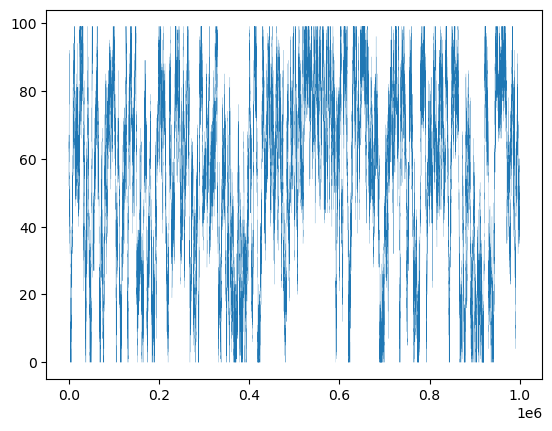

In [15]:
plt.plot(df_mcmc["idx_phi11"], linewidth = 0.1)